# Введение в обработку естественного языка
# Урок 12. Модель Transformer-2

# <font color='red'>Практическое задание</font>

### Домашнее задание к уроку 11

__Задание__

Взять тот же датасет, который был на вебинаре и предобученную модель для задачи суммаризации
1. Проверить насколько хорошо она суммаризирует
2.(дополнительно) Сделать генерацию заголовков для статьи (обучить модель для генерации заголовков)

Выполнил ___Соковнин ИЛ___

In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.2 MB/s 
     |████████████████████████████████| 101 kB 11.4 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 6.6 MB 39.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [3]:
!ls

gazeta_test.txt  gazeta_train.txt  gazeta_val.txt  sample_data


In [4]:
!pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1 summa lexrank sumy
!pip install --upgrade datasets razdel spacy networkx seaborn scipy tqdm tensorflow-text
!python -m spacy download ru_core_news_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 69 kB 7.2 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 10.1 MB 21.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.2 MB 32.3 MB/s 
     |████████████████████████████████| 371 kB 32.7 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=7a2e14bfe00facbd7b6b610c73e3dcfc445d0a5ac825bdce62b1e29886fbbdf6
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21712 sha256=ec047a5df863fad1d04

## Загрузим данные с помощью библиотеки datasets




In [5]:
# по сути данные те же можно пользоваться любым способом загрузки
from datasets import load_dataset

dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")["test"]

No config specified, defaulting to: gazeta/default


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Dataset gazeta downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## EDA (Exploratory data analysis)

Посмотрим на то, как устроен датасет

In [11]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [7]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [8]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [14]:
test_records[0]

{'date': '2020-02-14 16:39:11',
 'summary': 'В NASA назвали четыре миссии в дальний космос, которые в этом десятилетии могут быть запущены американцами. Среди них — две миссии по изучению Венеры, полет к спутнику Юпитера и экспедиция к Тритону, спутнику Нептуна.',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторы

In [15]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [16]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


Посчитаем статистику по словам

In [17]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [18]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


In [19]:
train_text_stats.lemma_vocabulary.most_common(50)

[(',', 53334),
 ('.', 38444),
 ('в', 27978),
 ('и', 15538),
 ('«', 14801),
 ('»', 14714),
 ('на', 11761),
 ('не', 7995),
 ('с', 7964),
 ('—', 7920),
 ('что', 7498),
 ('быть', 6416),
 ('по', 5473),
 ('он', 5240),
 ('год', 4383),
 ('это', 4376),
 ('который', 3995),
 ('а', 3235),
 ('о', 2983),
 ('к', 2871),
 ('из', 2791),
 ('тот', 2791),
 ('они', 2720),
 ('за', 2715),
 ('как', 2542),
 (')', 2507),
 ('(', 2502),
 ('но', 2471),
 ('свой', 2417),
 (':', 2349),
 ('для', 2242),
 ('россия', 2082),
 ('от', 2027),
 ('она', 1999),
 ('этот', 1953),
 ('у', 1860),
 ('мы', 1801),
 ('до', 1761),
 ('мочь', 1722),
 ('я', 1665),
 ('один', 1595),
 ('также', 1587),
 ('после', 1540),
 ('–', 1490),
 ('весь', 1426),
 ('всё', 1414),
 ('первый', 1369),
 ('стать', 1369),
 ('%', 1290),
 ('уже', 1274)]

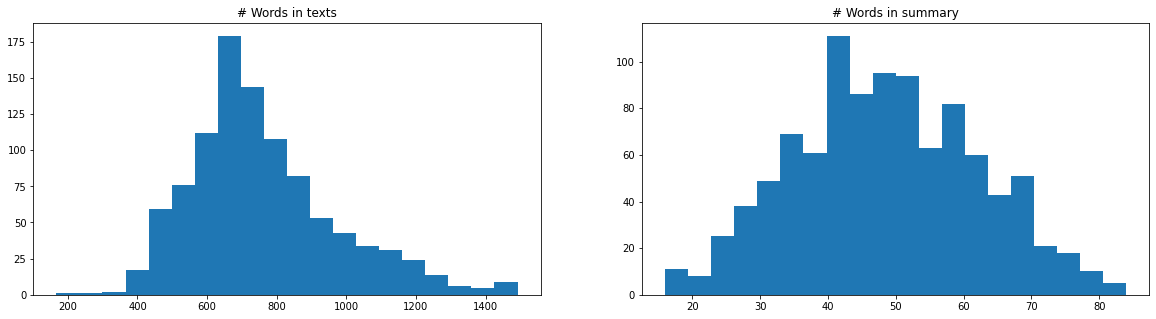

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

In [21]:
test_text_stats, test_summary_stats = collect_stats(test_records)
print("Test texts vocabulary size: ", len(test_text_stats.vocabulary))
print("Test texts lemma vocabulary size: ", len(test_text_stats.lemma_vocabulary))
print("Test summaries vocabulary size: ", len(test_summary_stats.vocabulary))
print("Test summaries lemma vocabulary size: ", len(test_summary_stats.lemma_vocabulary))
print("Test common lemmas summary vs text: ", len(set(test_text_stats.lemma_vocabulary.keys()) & set(test_summary_stats.lemma_vocabulary.keys())))

Test texts vocabulary size:  73282
Test texts lemma vocabulary size:  32583
Test summaries vocabulary size:  15196
Test summaries lemma vocabulary size:  8618
Test common lemmas summary vs text:  8353


In [22]:
test_text_stats.lemma_vocabulary.most_common(50)

[(',', 54104),
 ('.', 38406),
 ('в', 28069),
 ('и', 14555),
 ('«', 12789),
 ('»', 12716),
 ('на', 11741),
 ('что', 9225),
 ('—', 8528),
 ('с', 8173),
 ('не', 7279),
 ('по', 6354),
 ('быть', 6240),
 ('он', 6065),
 ('это', 5560),
 ('год', 4990),
 ('который', 3920),
 ('о', 3888),
 ('тот', 3200),
 ('они', 3082),
 ('как', 2981),
 ('из', 2868),
 ('она', 2832),
 ('к', 2828),
 ('россия', 2713),
 ('а', 2597),
 ('свой', 2542),
 ('для', 2473),
 ('за', 2402),
 ('также', 2105),
 ('этот', 2089),
 ('от', 2061),
 ('я', 1865),
 ('мочь', 1855),
 ('мы', 1755),
 ('у', 1725),
 ('но', 1699),
 ('страна', 1657),
 ('российский', 1589),
 ('(', 1583),
 (')', 1583),
 ('человек', 1583),
 ('президент', 1582),
 ('сша', 1578),
 ('при', 1564),
 ('до', 1523),
 ('один', 1510),
 ('после', 1506),
 ('время', 1500),
 ('весь', 1476)]

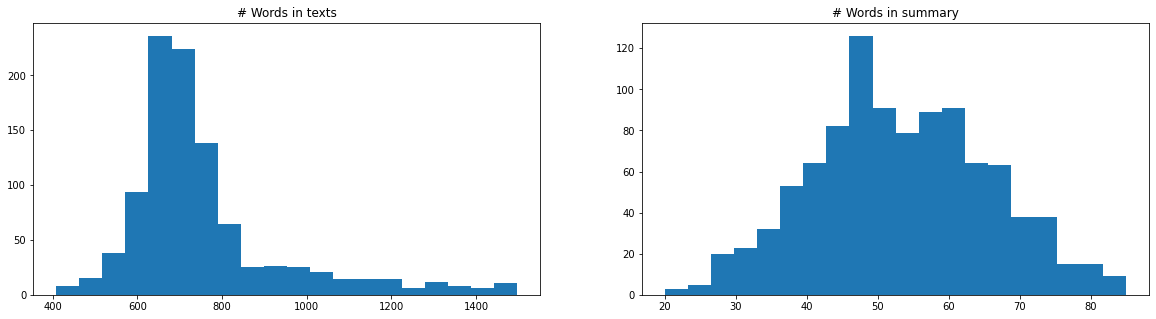

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(test_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(test_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

# Используем предобученную модель: [csebuetnlp/mT5_multilingual_XLSum](https://huggingface.co/csebuetnlp/mT5_multilingual_XLSum)

In [10]:
# huggingface.co/models
# Знакомимся с сообществом hugginfaсe, с его библиотекой transformers
!pip install transformers
!pip install transformers sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 4.1 MB/s 
     |████████████████████████████████| 6.6 MB 33.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


# Используем предобученную модель: IlyaGusev/mbart_ru_sum_gazeta

In [11]:
from transformers import MBartTokenizer, MBartForConditionalGeneration

model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)


model_mbart_ru_sum_gazeta = MBartForConditionalGeneration.from_pretrained(model_name)

article_text = "Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из выбранных полуфиналистов получит $3 млн на проработку концепции. Из четырех выбранных проектов NASA планирует отобрать две в 2021 году, чтобы профинансировать работу по их реализации в рамках программы Discovery. Два из четырех проектов посвящены исследованию Венеры, куда аппараты NASA не отправлялись уже свыше тридцати лет — с 1989 года, когда к этой планете был запущен зонд Magellan. Миссия VERITAS ( Venus Emissivity, Radio Science, InSAR, Topography, and Spectroscopy) призвана картировать поверхность Венеры для лучшего понимания геологической истории планеты и получения ответа на вопрос о причинах ее кардинальных отличий от Земли. Карта будет построена при помощи радара, установленного на орбитальном аппарате. В ходе миссии планируется узнать, продолжаются ли в наши дни на Венере тектонические и вулканические процессы. Кроме того, планируется картировать поверхность планеты в инфракрасном диапазоне. Миссия DAVINCI+ (Deep Atmosphere Venus Investigation of Noble gases, Chemistry and Imaging Plus) задумана для того, чтобы исследовать состав атмосферы Венеры, понять, как она формировалась и эволюционировала в прошлом, и ответить на вопрос о существовании когда-либо на планете жидкого океана. Сделать это планируется при помощи спускаемого аппарата, который будет проводить измерения от верхних слоев атмосферы до самой поверхности. Научные инструменты аппарата будут размещены внутри герметичного сферического корпуса, который должен защитить их от разрушительного воздействия высокой температуры атмосферы. + в названии миссии говорит о наличии в ее составе камер, которые будут присутствовать на борту орбитального и спускаемого аппаратов. «Проект DAVINCI+ пересекается по целям с российской миссией «Венера-Д», обе нацелены на посадку, поэтому в будущем возможно их совмещение в одном совместном проекте», — сказал «Газете.Ru» основатель проекта «Открытый космос» Виталий Егоров. Миссия TRIDENT должна исследовать Тритон — ледяной спутник Нептуна, известный ученым своей активностью. Данные, полученные американским зондом Voyager 2, показали, что поверхность Тритона активно обновляется. Ученые считают, что Тритон, на котором выпадает «снег» из органических веществ, может оказаться отличной целью для понимания вопросов происхождения аналогичных тел в Солнечной системе. Пролетев мимо Тритона, аппарат попытается картировать его поверхность, изучить активные процессы на его поверхности и определить, есть ли под его поверхностью жидкий океан. Миссия IVO (Io Volcano Observer) должна направиться к одному из самых интересных спутников Юпитера — Ио. Это тело с наиболее мощной вулканической активностью в Солнечной системе, которая поддерживается за счет мощного приливного воздействия со стороны Юпитера. Во время нескольких близких пролетов аппарат выяснит, как формируется лава на поверхности спутника."

input_ids = tokenizer(
    [article_text],
    max_length=600,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model_mbart_ru_sum_gazeta.generate(
    input_ids=input_ids,
    no_repeat_ngram_size=4
)[0]

summary = tokenizer.decode(output_ids, skip_special_tokens=True)
print(summary)

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.23G [00:00<?, ?B/s]

Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости.


In [3]:
# print(input_ids)

# Используем предобученную модель: csebuetnlp/mT5_multilingual_XLSum

In [12]:
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

# article_text = """Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down, the company said.  The policy includes the termination of accounts of anti-vaccine influencers.  Tech giants have been criticised for not doing more to counter false health information on their sites.  In July, US President Joe Biden said social media platforms were largely responsible for people's scepticism in getting vaccinated by spreading misinformation, and appealed for them to address the issue.  YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year, when it implemented a ban on content spreading misinformation about Covid vaccines.  In a blog post, the company said it had seen false claims about Covid jabs "spill over into misinformation about vaccines in general". The new policy covers long-approved vaccines, such as those against measles or hepatitis B.  "We're expanding our medical misinformation policies on YouTube with new guidelines on currently administered vaccines that are approved and confirmed to be safe and effective by local health authorities and the WHO," the post said, referring to the World Health Organization."""

# article_text = "Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из выбранных полуфиналистов получит $3 млн на проработку концепции. Из четырех выбранных проектов NASA планирует отобрать две в 2021 году, чтобы профинансировать работу по их реализации в рамках программы Discovery. Два из четырех проектов посвящены исследованию Венеры, куда аппараты NASA не отправлялись уже свыше тридцати лет — с 1989 года, когда к этой планете был запущен зонд Magellan. Миссия VERITAS ( Venus Emissivity, Radio Science, InSAR, Topography, and Spectroscopy) призвана картировать поверхность Венеры для лучшего понимания геологической истории планеты и получения ответа на вопрос о причинах ее кардинальных отличий от Земли. Карта будет построена при помощи радара, установленного на орбитальном аппарате. В ходе миссии планируется узнать, продолжаются ли в наши дни на Венере тектонические и вулканические процессы. Кроме того, планируется картировать поверхность планеты в инфракрасном диапазоне. Миссия DAVINCI+ (Deep Atmosphere Venus Investigation of Noble gases, Chemistry and Imaging Plus) задумана для того, чтобы исследовать состав атмосферы Венеры, понять, как она формировалась и эволюционировала в прошлом, и ответить на вопрос о существовании когда-либо на планете жидкого океана. Сделать это планируется при помощи спускаемого аппарата, который будет проводить измерения от верхних слоев атмосферы до самой поверхности. Научные инструменты аппарата будут размещены внутри герметичного сферического корпуса, который должен защитить их от разрушительного воздействия высокой температуры атмосферы. + в названии миссии говорит о наличии в ее составе камер, которые будут присутствовать на борту орбитального и спускаемого аппаратов. «Проект DAVINCI+ пересекается по целям с российской миссией «Венера-Д», обе нацелены на посадку, поэтому в будущем возможно их совмещение в одном совместном проекте», — сказал «Газете.Ru» основатель проекта «Открытый космос» Виталий Егоров. Миссия TRIDENT должна исследовать Тритон — ледяной спутник Нептуна, известный ученым своей активностью. Данные, полученные американским зондом Voyager 2, показали, что поверхность Тритона активно обновляется. Ученые считают, что Тритон, на котором выпадает «снег» из органических веществ, может оказаться отличной целью для понимания вопросов происхождения аналогичных тел в Солнечной системе. Пролетев мимо Тритона, аппарат попытается картировать его поверхность, изучить активные процессы на его поверхности и определить, есть ли под его поверхностью жидкий океан. Миссия IVO (Io Volcano Observer) должна направиться к одному из самых интересных спутников Юпитера — Ио. Это тело с наиболее мощной вулканической активностью в Солнечной системе, которая поддерживается за счет мощного приливного воздействия со стороны Юпитера. Во время нескольких близких пролетов аппарат выяснит, как формируется лава на поверхности спутника."

test_records[0]["text"]

model_name = "csebuetnlp/mT5_multilingual_XLSum"

# tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")
model_mT5_multilingual_XLSum = AutoModelForSeq2SeqLM.from_pretrained(model_name)

input_ids = tokenizer(
    [WHITESPACE_HANDLER(article_text)],
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=512
)["input_ids"]

# print(input_ids)

output_ids = model_mT5_multilingual_XLSum.generate(
    input_ids=input_ids,
    max_length=84,
    no_repeat_ngram_size=2,
    num_beams=4
)[0]


summary = tokenizer.decode(
    output_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)

print(summary)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/730 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


Downloading:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

Космические миссии, которые могут дать ответы на вопросы о происхождении тел Солнечной системы, будут запущены в 2021 году.


In [13]:
def model_mT5_multilingual_XLSum_summary(article_text, model): 
    """ 
        Самморизация.
        Используем предобученную модель: csebuetnlp/mT5_multilingual_XLSum
    """
    # model_mT5_multilingual_XLSum = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    input_ids = tokenizer(
        [WHITESPACE_HANDLER(article_text)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )["input_ids"]

    # print(input_ids)

    output_ids = model_mT5_multilingual_XLSum.generate(
        input_ids=input_ids,
        max_length=84,
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]


    summary = tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return summary

In [ ]:
# test_records[0]["text"]

In [14]:
article_text = test_records[0]["text"]
summary = model_mT5_multilingual_XLSum_summary(article_text, model_mT5_multilingual_XLSum)

print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 

In [16]:
article_text = test_records[1]["text"]
summary = model_mT5_multilingual_XLSum_summary(article_text, model_mT5_multilingual_XLSum)

print()
print("Текст: {}".format(test_records[1]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[1]["summary"]))


Текст: Около 11 тысяч зрителей увидели все самое лучшее, что есть на сегодняшний день в культуре Бурятии. В Кремле выступил Бурятский государственный академический театр оперы и балета, Национальный цирк, Бурятский национальный театр песни и танца «Байкал», ставший победителем шоу «Танцуют все!» на телеканале «Россия», а также другие профессиональные и самодеятельные коллективы региона. Более 300 артистов из одного региона на главной сцене страны - похоже это рекорд России. Зрителям рассказали, что Республике Бурятия, чье население составляет 1 миллион человек, сохранилась и развивается культура десятков национальностей, включая русских, бурятов, староверов (семейских), эвенков. И все они были представлены в Москве. Как писали после шоу зрители в соцсетях: «А мы думали, что в Бурятии только буряты живут…». Для неподготовленного зрителя это вообще были вечера открытий. Например, когда еще в Кремлевском дворце выстраивалась очередь из желающих попасть на прием к врачам-пульсологам и лам

In [17]:
article_text = test_records[2]["text"]
summary = model_mT5_multilingual_XLSum_summary(article_text, model_mT5_multilingual_XLSum)

print()
print("Текст: {}".format(test_records[2]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[2]["summary"]))


Текст: 7 ноября в Белоруссии прошли выборы членов совета республики — верхней палаты парламента. В столице и шести областях республики были избраны по восемь сенаторов. Еще восемь членов совета назначит президент Белоруссии Александр Лукашенко. Голосование осуществлялось на заседаниях депутатов местных советов базового уровня и Мингорсовета. Выборы в верхнюю палату парламента прошли безальтернативно — президиумы районных и городских советов депутатов, а также исполнительных комитетов выдвинули восемь претендентов на восемь мест. Для победы каждому кандидату необходимо было набрать простое большинство голосов. Из предыдущего состава верхней палаты парламента планировали переизбраться всего 11 человек, то есть новый состав совета республики будет значительно обновлен. Все выдвинутые кандидатуры получили поддержку депутатов. Большинство членов совета республики беспартийные — это одна из главных особенностей белорусского парламента. Среди утвержденных сенаторов руководители промышленных 

__Вывод__

Качество суммаризации достаточно высокое

In [19]:
article_text = test_records[0]["text"]
summary = model_mT5_multilingual_XLSum_summary(article_text, model_mbart_ru_sum_gazeta)

print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 